## Load Data

In [6]:
import pickle
import os

from src.utils import load_replay_buffer
from src.learning.symmetry.kernel_approx import KernelFrameEstimator

FOLDER_NAME: str="data/local/experiment/circle_rotation"
TASK_NAMES=["sac_circle_rotation_task_0", "sac_circle_rotation_task_1", "sac_circle_rotation_task_2", "sac_circle_rotation_task_3"]

LOAD_WHAT:str="next_observations"
KERNEL_DIM=1
N_SAMPLES=50_000


def load_replay_buffer_and_kernel(task_name:str, load_what:str, kernel_dim: int, n_samples:int, folder_name):
    """Loads samples and kernel evaluator of a task."""

    assert load_what in ["observations", "actions", "next_observations"], "Learn hereditary geometry for states, actions or next states."

    buffer_name= os.path.join(folder_name, f"{task_name}_replay_buffer.pkl")
    kernel_name= os.path.join(folder_name, f"{task_name}_kernel_bases.pkl")


    buffer= load_replay_buffer(buffer_name, N_steps=n_samples)
    ps=buffer[load_what]
    print(f"Loaded {load_what} from {buffer_name} with shape {ps.shape}")

    # Load kernel bases
    frameestimator=KernelFrameEstimator(ps=ps, kernel_dim=kernel_dim)
    with open(kernel_name, 'rb') as f:
        kernel_samples = pickle.load(f)
    frameestimator.set_frame(frame=kernel_samples)

    return ps, frameestimator

tasks_ps, tasks_frameestimators=[], []
for task_name in TASK_NAMES:
    ps, frameestimator = load_replay_buffer_and_kernel(task_name, LOAD_WHAT, KERNEL_DIM, N_SAMPLES, FOLDER_NAME)
    tasks_ps.append(ps)
    tasks_frameestimators.append(frameestimator)

/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/utils.py:68: UserWarning: Replay buffer contains more samples than selected.
  warnings.warn("Replay buffer contains more samples than selected.")


Loaded next_observations from data/local/experiment/circle_rotation/sac_circle_rotation_task_0_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


Loaded next_observations from data/local/experiment/circle_rotation/sac_circle_rotation_task_1_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


Loaded next_observations from data/local/experiment/circle_rotation/sac_circle_rotation_task_2_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


Loaded next_observations from data/local/experiment/circle_rotation/sac_circle_rotation_task_3_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


In [12]:
%load_ext autoreload
%autoreload 2

import torch
from src.learning.symmetry_discovery.hereditary_geometry_discovery import HereditaryGeometryDiscovery
ORACLE_GENERATOR=torch.tensor([[0, -1], [1,0]], dtype=torch.float32, requires_grad=False).unsqueeze(0)
train_goal_locations=[
    {'goal': torch.tensor([-0.70506063,  0.70914702])},
 {'goal': torch.tensor([ 0.95243384, -0.30474544])},
 {'goal': torch.tensor([-0.11289421, -0.99360701])},
 {'goal': torch.tensor([-0.81394263, -0.58094525])}]

class Affine2D(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim, bias=True)

    def forward(self, x):
        return self.linear(x)

SEED=42
LEARN_LEFT_ACTIONS=False
LEARN_GENERATOR=False

ENCODER=Affine2D(input_dim=2, output_dim=2)
DECODER=Affine2D(input_dim=2, output_dim=2)

her_geo_dis=HereditaryGeometryDiscovery(tasks_ps=tasks_ps,
                                        tasks_frameestimators=tasks_frameestimators, 
                                        kernel_dim=KERNEL_DIM, 
                                        batch_size=128, 
                                        seed=SEED, 
                                        bandwidth=0.5,
                                        learn_encoder_decoder=True,
                                        task_specifications=train_goal_locations,
                                        learn_left_actions=LEARN_LEFT_ACTIONS,
                                        learn_generator=LEARN_GENERATOR,
                                        oracle_generator=ORACLE_GENERATOR,
                                        encoder=ENCODER,
                                        decoder=DECODER)
her_geo_dis.optimize(n_steps=50_000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Inferring left-action:   0%|          | 0/50000 [00:00<?, ?it/s]/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/hereditary_geometry_discovery.py:195: UserWarning: Using oracle generator. Only use for debugging.
  warnings.warn("Using oracle generator. Only use for debugging.")
Symmetry Loss: 0.0 | Reconstruction Loss: 0.476: 100%|██████████| 50000/50000 [01:05<00:00, 764.79it/s] 


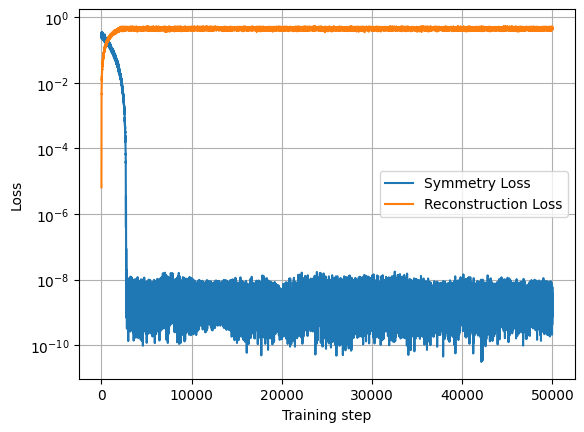

In [13]:
import matplotlib.pyplot as plt

losses=her_geo_dis.losses
plt.plot(losses['symmetry'], label='Symmetry Loss')
plt.plot(losses['reconstruction'], label='Reconstruction Loss')
plt.yscale("log")
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Training step")
plt.legend()

## Compare Lassos

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
from src.learning.symmetry_discovery.hereditary_geometry_discovery import HereditaryGeometryDiscovery
ORACLE_KERNEL=True

lasso_strenghts=[0, 0.05, 0.1, 0.2, 0.4, 0.8, 1.6]
N_RUNS=5
Seeds= [39, 42, 43, 44, 45]
N_TASKS=4
N_steps=10_000
losses_symmetry=np.zeros((len(lasso_strenghts), N_RUNS, N_steps))
losses_reconstruction=np.zeros((len(lasso_strenghts), N_RUNS, N_steps))
losses_symmetry_reg=np.zeros((len(lasso_strenghts), N_RUNS, N_steps))

for idx_lasso, lasso_strength in enumerate(lasso_strenghts):
    for idx_run, run in enumerate(range(N_RUNS)):
        print(f"Run {run+1}/{N_RUNS} for lasso strength {lasso_strength}")

        ENCODER=Affine2D(input_dim=2, output_dim=2)
        DECODER=Affine2D(input_dim=2, output_dim=2)

        her_geo_dis=HereditaryGeometryDiscovery(tasks_ps=tasks_ps,
                                                tasks_frameestimators=tasks_frameestimators, 
                                                kernel_dim=KERNEL_DIM, 
                                                batch_size=128, 
                                                seed=Seeds[idx_run], 
                                                bandwidth=0.5,
                                                learn_encoder_decoder=True,
                                                task_specifications=train_goal_locations,
                                                learn_left_actions=LEARN_LEFT_ACTIONS,
                                                learn_generator=LEARN_GENERATOR,
                                                oracle_generator=ORACLE_GENERATOR,
                                                encoder=ENCODER,
                                                decoder=DECODER)
        her_geo_dis.optimize(n_steps=N_steps)
        losses=her_geo_dis.losses
        del her_geo_dis

        losses_symmetry[idx_lasso, run] = losses["symmetry"]
        losses_reconstruction[idx_lasso, run] = losses["reconstruction"]
        losses_symmetry_reg[idx_lasso, run] = losses["symmetry_reg"]